In [1]:
# ml libraries
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# nlp libraries
import nltk
from nltk.corpus import stopwords
import spacy

import re
import pickle

from supporting_modules.text_cleaning import PATTERNS
import supporting_modules.text_cleaning as stc
import supporting_modules.data_visualization as sdv
import supporting_modules.corpus_preprocessing as scp

# step 0: Load data from dataset

Firstly, we need to load the dataset for further analysis. In this case, it will be the dataset named **"Large Movie Review Dataset"**. It is downloaded from https://ai.stanford.edu/~amaas/data/sentiment/

The sentiment values in the text corpus from Stanford Dataset is either positive or negative. More info about these data is in `README` file. After loading, the data is of sklearn Bunch type, so we have to retrieve list of text data and numpy.ndarray with the labels.

This data is not included in the project. To use them, you can download them from the mentioned website and then unpack them to the appropriate directory.

In my case, the directory is one level above the project main direcotry.

### Required imports

In [2]:
train_data = load_files("../datasets/aclImdb_v1/aclImdb/train")
test_data = load_files("../datasets/aclImdb_v1/aclImdb/test")

reviews_train, y_train = train_data.data, train_data.target
reviews_test, y_test = test_data.data, test_data.target

The types of each data element are listed below. As we can see the data are saved as bytes. The length of the training data set is equal to 75,000. In the README file, it was mentioned that the quantity of positive and negative reviews is equal to 50,000 (per 25,000 in training and test part accordingly). The difference equal to 50,000 is caused by data labeled as 'unsup'. This part of the data includes an additional 50,000 unlabeled documents for unsupervised learning.

In the first part of the project, this data will not be needed. Therefore, they will be subtracted from the training pool (there is no data with this label in the test pool).

In [3]:
print(f"train_data data type: {type(train_data)}")
print(f"reviews_train type: {type(reviews_train)}")
print(f"the type of single review: {type(reviews_train[0])}")
print(f"reviews_test type: {type(reviews_test)}")
print(f"text_train data length: {len(reviews_train)}")
print(f"text_test data length: {len(reviews_test)}")

train_data data type: <class 'sklearn.utils._bunch.Bunch'>
reviews_train type: <class 'list'>
the type of single review: <class 'bytes'>
reviews_test type: <class 'list'>
text_train data length: 75000
text_test data length: 25000


In [4]:
# The data in the training set are distributed in the proportions of 12500, 12500, 50000
# In next steps I remove those items that are 'unsup' 

print(f"The proportions of the data distribution: {np.bincount(y_train)}")
print(f"Numeric values of labels: {np.unique(y_train, return_counts=True)}")
print(f"Label names: {train_data.target_names}\n")

print(f"The proportions of the data distribution: {np.bincount(y_test)}")
print(f"Numeric values of labels: {np.unique(y_test, return_counts=True)}")
print(f"Label names: {test_data.target_names}\n")

The proportions of the data distribution: [12500 12500 50000]
Numeric values of labels: (array([0, 1, 2]), array([12500, 12500, 50000]))
Label names: ['neg', 'pos', 'unsup']

The proportions of the data distribution: [12500 12500]
Numeric values of labels: (array([0, 1]), array([12500, 12500]))
Label names: ['neg', 'pos']



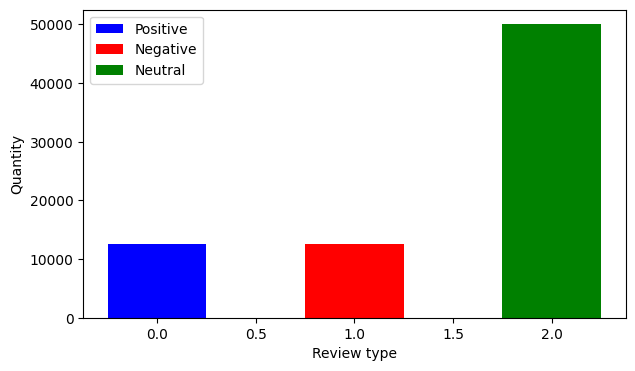

In [5]:
sdv.count_per_label(np.bincount(y_train), ('Positive', 'Negative', 'Neutral'))

In [6]:
# lets see how the reviews looks like

print("POSITIVE REVIEW EXAMPLE:\n".upper(), reviews_train[3], "\n\n", "*" * 100, "\n")
print("NEGATIVE REVIEW EXAMPLE:\n", reviews_train[126])

POSITIVE REVIEW EXAMPLE:
 b"Dan Katzir has produced a wonderful film that takes us on a roller-coaster ride through a real romance set in the troubles surrounding modern Israel.<br /><br />For anyone who's ever been in love, the film brings back the uncertainties, the insecurities and heartache that make love so bitter-sweet. The atmosphere of fear and isolation that came with the difficult times in Israel at that time just serve to intensify the feeling. Instantly, you are drawn in to Dan's plight, and you can't fail to be deeply moved.<br /><br />You can't write drama and passion like this - the contrast between the realities of Dan's desperate, snatched relationship with Iris, and the realities of a state in turmoil make this eminently watchable. If you have an ounce of passion, and have ever been in love, see this film." 

 **************************************************************************************************** 

NEGATIVE REVIEW EXAMPLE:
 b"This film comes as the ultima

## Remove the data without labels

The data are cleaned using function defined in `additional_modules/test_cleaning`. 

After this action we'll have balanced binary data in both datasets (training and test). The data after applying stc.clear_reviews_from_dataset() function looks like:

In [7]:
reviews_train_binary, y_train_binary = stc.clear_reviews_from_dataset(y_train, reviews_train)

In [8]:
# Our data after applying stc.clear_reviews_from_dataset() function

print(f"The proportions of the data distribution: {np.bincount(y_train_binary)}")
print(f"Numeric values of labels: {np.unique(y_train_binary, return_counts=True)}")

The proportions of the data distribution: [12500 12500]
Numeric values of labels: (array([0, 1]), array([12500, 12500]))


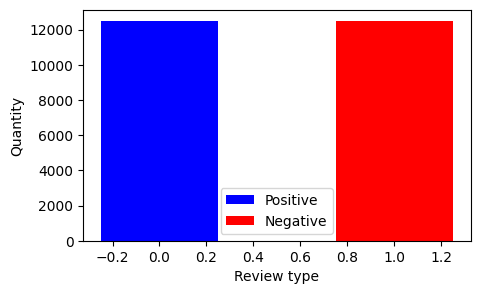

In [9]:
sdv.count_per_label(np.bincount(y_train_binary), ('Positive', 'Negative', 'Neutral'))

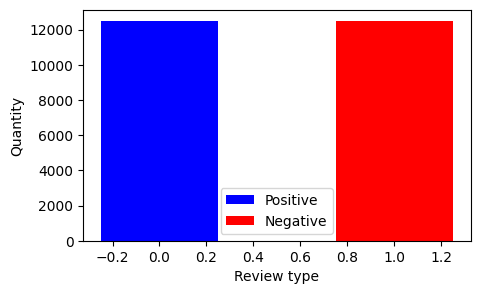

In [10]:
sdv.count_per_label(np.bincount(y_test), ('Positive', 'Negative', 'Neutral'))

Unique reviews in the both datastes:

In [11]:
len(set(reviews_train_binary)), len(reviews_train_binary)

(24904, 25000)

In [12]:
len(set(reviews_test)), len(reviews_test)

(24801, 25000)

### Word quantity per review histograms

Below there are the histograms for data before text cleaning. The most common length of reviews  is between (more-less) 70 and 700 words per text in both parts (train and test). In the next steps, the documents will be cleaned so these values will be decreased. 

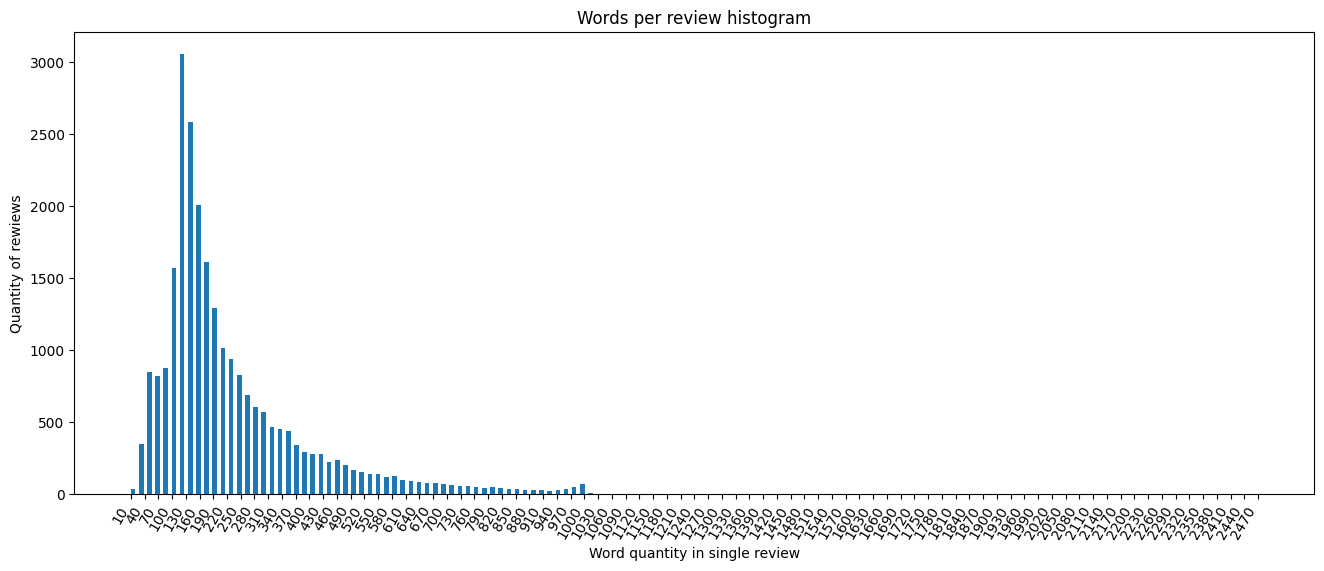

In [13]:
word_counts = sdv.make_count_histogram(reviews_train_binary, 30)

In [14]:
# Two the shortest reviews in our train dataset

for text in reviews_train_binary:
    if len(text.split()) <= min(list(word_counts.keys())):
        print(text)

b"I wouldn't rent this one even on dollar rental night."
b'This movie is terrible but it has some good effects.'


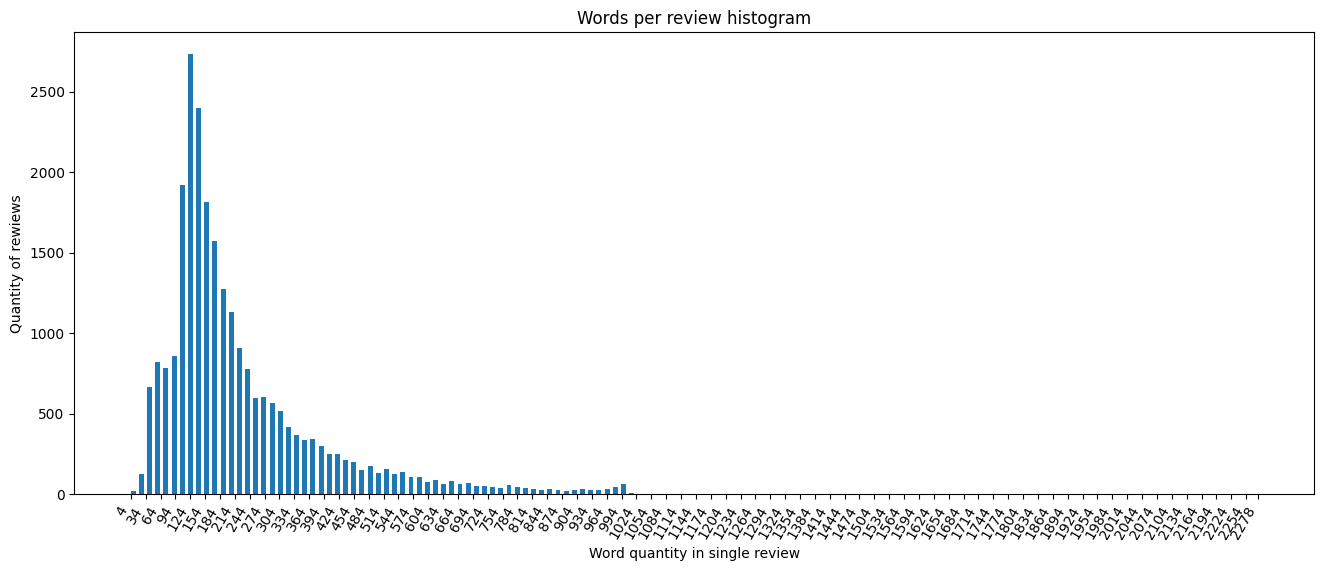

In [15]:
word_counts = sdv.make_count_histogram(reviews_test, 30)

In [16]:
# Two the shortest reviews in our test dataset

for text in reviews_test:
    if len(text.split()) <= min(list(word_counts.keys())):
        print(text)

b'Primary plot!Primary direction!Poor interpretation.'


# step 1: Text data cleaning

## Convert all letters to lowercase

In case of sentiment analysis in movie reviews convertion to the lowercase can be helpfull in the next steps like tokenization, stemming and so on. 

In [17]:
reviews_train_binary = [review.lower() for review in reviews_train_binary]

### Checking if the text contains html tags

 Let's check if there are any HTML tags in our reviews and if so let's take a look at what they look like.
The checking is made using the function **`get_occurance_in_dataset()`** defined in **`supporting_modules/text_cleaning`** (aliased as **`srt`** in this notebook). 
As it is visible below not all results are proper HTML tags some of them look like such elements but they aren't. For instance in the first returned we have open sign "<" directly behind this sign there's the space and the reguralar text data till the closing proper HTLM tag \<br /\> . Similar situation in the next three returned and the last one. The rest of returned values are proper or almost proper tags.

In [18]:
stc.get_occurance_in_dataset(reviews_train_binary)

{"< $600 per screen its opening weekend, and just over $400 each, after its month's theater run in latter 2002. overall gross was $261k, which i'd doubt could cover cast and crew's hotel and food for a week on location.<br />",
 '< and make notes for my partial "review" to show how foolish the movie is. "resident evil" (horror) or "dude, where\'s my car?" (comedy) i can watch over and over again and still enjoy! but this...!<br />',
 '< than 30 minutes of watching, being bored and irritated. <br />',
 '< who was to be a victim, but woman-power trumps evil scientist every time.<br />',
 '</em>',
 '</i>',
 '</spoiler>',
 '<3 <br />',
 '<<<sigh>',
 '<=8.<br />',
 '<br />',
 '<em>',
 '<grin>',
 '<hr>',
 '<http://rogerebert.suntimes.com/apps/pbcs.dll/section?category=answerman>',
 '<i>',
 '<sp?) classic "romeo & juliet". guess i\'ll have to rent that next.<br />',
 '<spoiler>'}

## Removal of html tags from the reviews

Before removing the html tags, problematic fragments found as tags but which are not - should be taken into attention. In order to remove such elements - the replacement "\<sp\\?\\)|<+ " by "" seems like a good idea - because we have in such cases either tags started with "\<" + space or "\<sp?)".

After removing them, only tags and tag-like elements that look redundant will remain in the documents. Then these elements will be repraced by blank string. 

Both activities are performed using function **`clear_substr_in_texts()`** defined in **`supporting_modules/text_cleaning`** (aliased as **`srt`** in this notebook). 



In [19]:
# remove tag-like elements from train data
reviews_train_binary = stc.clear_substr_in_texts(reviews_train_binary, \
                                                 pattern=re.compile(r"<sp\?\)|<+ "))

# show if tag-like element list looks ok
print("TAGS LEFT:")
print(stc.get_occurance_in_dataset(reviews_train_binary))


REMOVED SUBSTRINGS SAMPLE:
 {'< ', '<<<<<<<<<<<< ', '<<<<<<<<<<<<<<<<<<<<<<<< ', '<<<<<<<<<<<<<<<<<<<< ', '<sp?)'}
TAGS LEFT:
{'<br />', '<=8.<br />', '<hr>', '<3 <br />', '<<<sigh>', '<grin>', '</i>', '<spoiler>', '<em>', '</em>', '<http://rogerebert.suntimes.com/apps/pbcs.dll/section?category=answerman>', '</spoiler>', '<i>'}


The occurrence of a tag containing at least one "<" character and a space occurs quite often, therefore both the regex for removing full HTML tags and those "<+ " (at least one < character followed by a space) will be added to the permanent PATTERNS dictionary in the module `supporting_modules/text_cleaning`. 

### Remove HTML tags from train data

Finally let's remove remaining tags and tags-like elements. 

In [20]:
reviews_train_binary = stc.clear_substr_in_texts(reviews_train_binary, \
                                                 pattern=PATTERNS['html_tags'])

# show whether any tag-like elements remain
print("TAGS LEFT:")
len(stc.get_occurance_in_dataset(reviews_train_binary))


REMOVED SUBSTRINGS SAMPLE:
 {'<br />', '<=8.<br />', '<hr>', '<3 <br />', '<<<sigh>', '<grin>', '</i>', '<spoiler>', '<em>', '</em>', '<http://rogerebert.suntimes.com/apps/pbcs.dll/section?category=answerman>', '</spoiler>', '<i>'}
TAGS LEFT:


0

## Remove http addresses from review content

In order to deleting http links from review contents the same function as previously (**`clear_substr_in_texts()`**) is used with different pattern.

In [21]:
reviews_train_binary = stc.clear_substr_in_texts(reviews_train_binary, 
                                                 PATTERNS['http_addr'], "") 


REMOVED SUBSTRINGS SAMPLE:
 {'www.', 'http://'}


## Email addresses in the corups

Now let's check if thre are any email addresses in our courpus. Such values (simiraly as the previously removed data) do not carry value related to feelings about the rated movies.

But as you can see not all values that have the format similar to the email address is an email address indead. 

#### Check the train data

In [22]:
print(stc.get_occurance_in_dataset(reviews_train_binary, PATTERNS['email_addr']))

{'co@k",', 'dakota_loves_it@hot', '@#$%."', 'di@k', 'bits@midohio.net(new', 'bulls$@t,', 'kywildflower16@hotmail.com', 'mindf@ck', 'nfny40@yahoo.com', '%$@#', 'f#@k!ng', 'deusexmachina529@aol.com', 'vannoord@let.rug.nlthe', 'f@**', '&^@_+#!*', 'movie.deniselacey2000@yahoo.com', '$*@(%&', 's@*t', 'f#@k', '@*!^', 'bull!?#@', 'cartwrightbride@yahoo.com', '&*%#@#^', 'invinoveritas1@aol.com', 'iamaseal2@yahoo.com', 's@#t', '(bighouseaz@yahoo.com).', 'foxbarking@yahoo.com', '(sonarman65@yahoo.com)', '$^@%.', 'f@ckin', '#@$%#@$', '@', '"&$*@$', 'tight-@ss', '$%&@', 'vannoord@let.rug.nl', 'darkangel_1627@yahoo.com.', '"okul-d@bbe"', 'f*@#', 'f@ck', 'f@#king', '@#$0&%!!"', '*@$#', 'cr@p.', '"f@g-hag"', '@#%&', '@#$%!???"', 's#@t.', '(daneldorado@yahoo.com)', '(jpieczanski@sidwell.edu)', 'l.swanberg@yahoo.com', 'dmd2222@verizon.net.i', '(whiteflokati@hotmail.com)', 'f^@ks', 'sh#¤@t!definitely', 'tawnyteel@yahoo.com', 'f#@%ing', '#%$@ers!!!', 'w@nk', 'w@nk.', '*@#%', 'f*@!', 'horsecoach4hire@hotm

## Email regex format in the corups - conclusion

Some of these strings that match the pattern that matches email addresses are actually disguised profanity. They certainly express emotions, but the percentage of such sequences in the entire corpus seems to be negligible.
The **`corpus_docs_word_frequency()`** defined in **`supporting_modules/text_cleaning`** module was used to check. 

For comparison, 2 lighter "obscene words" were checked also as you can see they occur in the corpus. So those filled with characters like "#%@$#@" we can rather remove. They will not significantly affect the representation of these words in the data (the actual words of this type will be leave alone :-) ). So those data will be removed from both corpuses. 

In [23]:
words_to_check = ('s#@t', 'f*@!',  'bull!?#@')
words_to_check_2 = stc.rude_words

In [24]:
stc.corpus_docs_word_frequency(reviews_train_binary, words_to_check)

Word 's#@t' occurs 1 times in the corpus.
Word 's#@t' occurs in 1 documents.

Word 'f*@!' occurs 1 times in the corpus.
Word 'f*@!' occurs in 1 documents.

Word 'bull!?#@' occurs 1 times in the corpus.
Word 'bull!?#@' occurs in 1 documents.



In [25]:
stc.corpus_docs_word_frequency(reviews_train_binary, words_to_check_2)

Word 'sh#@%#' occurs 85 times in the corpus.
Word 'sh#@%#' occurs in 71 documents.

Word 'bu#@%#' occurs 23 times in the corpus.
Word 'bu#@%#' occurs in 21 documents.

Word 'da#@%#' occurs 461 times in the corpus.
Word 'da#@%#' occurs in 421 documents.



### Clear reviews from substrings that have format similar to the email


In [26]:
reviews_train_binary = stc.clear_substr_in_texts(reviews_train_binary, 
                                                 PATTERNS['email_addr'], "", 20) 


REMOVED SUBSTRINGS SAMPLE:
 ['co@k",', 'dakota_loves_it@hot', '@#$%."', 'di@k', 'bits@midohio.net(new', 'bulls$@t,', 'kywildflower16@hotmail.com', 'mindf@ck', 'nfny40@yahoo.com', '%$@#', 'f#@k!ng', 'deusexmachina529@aol.com', 'vannoord@let.rug.nlthe', 'f@**', '&^@_+#!*', 'movie.deniselacey2000@yahoo.com', '$*@(%&', 's@*t', 'f#@k', '@*!^']


## Remove digits

The numbers in  analized topic do not carry too much value, so they seem to be an element that can be removed. Of course, the movie rating can be a number, but in this case it's more of a sought-after label than what we want to have in the text.

In [27]:
reviews_train_binary = stc.clear_substr_in_texts(reviews_train_binary, 
                                                 PATTERNS['digits'], "", 20) 


REMOVED SUBSTRINGS SAMPLE:
 ['7600', '002', '80', '498', '262', '170', '160', '201', '111', '203', '223', '91', '7212', '123', '330', '1956', '90210', '1824', '270', '222']


## Summary of the "Text data cleaning" step

After completing this stage, the **`text_data_cleanup()`** function was created  for easier preprocessing new data in the same way (test data for example). It includes activities performed in the sub-sections of the "Text data cleaning" section. The function is saved in module **`supporting_modules/corpus_preprocessing`**

It remains to clean the text of **punctuation marks**, but due to the "stopwords" problem described below (**Stopwords** section) - this activity will be done later.




### Saving step as a pickle

Because the data prepared in this step is ready for further processing maybe the good idea is to save it as a picle.

In [28]:
# Path to the file
output_file = "../datasets/reviews_train_binary_step_1.pickle"

# save the corpus as a pickle
with open(output_file, 'wb') as f:
    pickle.dump(reviews_train_binary, f)

### Loading saved pickle

If you start this jupyter notebook from here, load the imports from the beginning of the notebook and then run the cell below to get the preprocessed data:

In [29]:
# Load the data from pickle files

input_file = "../datasets/reviews_train_binary_step_1.pickle"

with open(input_file, 'rb') as f:
    reviews_train_binary = pickle.load(f)

# step 2: Further preprocessing of text data

## Tokenization

In this project `word_tokenize` from nltk library is used. It is a tokenizer based on `nltk.TreebankWordTokenizer`. Before applying it the text data will be possible the firstly download of required resources is needed. 

In [30]:
# nltk.download()
# nltk.word_tokenize()

Before tokenization process let's take a look what the stopword list looks like and if it fits to considering problem. Tokenization will be done after this analysis is completed.

## nltk stopword list

Before removing stopwords (most common words with very small or none informative value) - let's see what words can we expect in such a collection. In this case one of most popular list of such words will be used `stopwords` from `nltk` library. 

In [31]:
from nltk.corpus import stopwords

stop_words_list = stopwords.words("english")

print(stop_words_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### note on stopwords analysis:

As it is visible in the list above, some of the words are abbreviated form of negation (the shortcut for word "not"). In case of sentiment analysis such negations looks like important. For example senteces: "The movie was good" and "The movie wasn't good" after removing stopwords will look the same despite they inform about completely different opinion about movie. If such words would be removed perharps the some important information would be lost. 

In [32]:
"was" in stop_words_list, "wasn't" in stop_words_list, "not" in stop_words_list, "no" in stop_words_list

(True, True, True, True)

Let's heck how many such words appears in stopwords list:

In [33]:
for word in stop_words_list: 
    if "'" in word:
        print(word, end=", ")

you're, you've, you'll, you'd, she's, it's, that'll, don't, should've, aren't, couldn't, didn't, doesn't, hadn't, hasn't, haven't, isn't, mightn't, mustn't, needn't, shan't, shouldn't, wasn't, weren't, won't, wouldn't, 

It looks that all words with suffix "'t" should be removed from stop words. Let's do this. 

First let's check words ending in 't or n (some words are abbreviations of bes 't, e.g. "musn"):

In [34]:
not_for_remove = [ stopw for stopw in stop_words_list if stopw[-2:] == "'t" or stopw[-1] == "n"]
print(not_for_remove)

['been', 'an', 'between', 'down', 'in', 'on', 'again', 'then', 'when', 'own', 'than', 'can', 'don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]


### Stop words list customization

The conditonal statement applied above is not prefect. Some words returned there are of course stop words that shoulen't be exclude but let's take returned list and erase them manually. The ***not_for_remove*** set after this action looks like below.

Based on the previous stopwords, a new list was created that does not contain problematic negative words.

In [35]:
not_for_remove = ['don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 
                  'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', 
                  "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 
                  'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

Now let's clear the stop_words_list of these words. 

In [36]:
print(f"before: {len(stop_words_list)} with {len(not_for_remove)} not stopwords inside." )

# remove not stopwords
stop_words_list = list(set(stop_words_list) - set(not_for_remove))

print("after: ", len(stop_words_list))

before: 179 with 37 not stopwords inside.
after:  142


_____________________________________________________________________________________________________________


The list of stopwords (**stop_words_list**) that will be used in the next steps is now prepared. It is saved in `supporting_modules/corpus_preprocessing` module. 

**Tokenization and deleting stopwords will be conducted once the negation words normalization will be done!**

## Normalization (in the case of negations)

### Explanation

Below, in order to show how much data we could lose, a previously defined function was performed to check how often a given word occurs in the corpus and in how many documents. You can see that these are large numbers and it would not be good to lose such a large amount of information.

In [37]:
# examples of words with not 't in reviews_train_binary corpus

stc.corpus_docs_word_frequency(reviews_train_binary, ["don't", "don ", "do not" , "wasn't", "weren't", "doesn't", "ain't"])

Word 'don't' occurs 8457 times in the corpus.
Word 'don't' occurs in 6276 documents.

Word 'don ' occurs 972 times in the corpus.
Word 'don ' occurs in 741 documents.

Word 'do not' occurs 1213 times in the corpus.
Word 'do not' occurs in 1070 documents.

Word 'wasn't' occurs 2308 times in the corpus.
Word 'wasn't' occurs in 1927 documents.

Word 'weren't' occurs 491 times in the corpus.
Word 'weren't' occurs in 461 documents.

Word 'doesn't' occurs 4533 times in the corpus.
Word 'doesn't' occurs in 3617 documents.

Word 'ain't' occurs 174 times in the corpus.
Word 'ain't' occurs in 164 documents.



Firstly the list of values for replacement is created. Once it is done the list of keys (shortcut words that will be searched in corpus) should be fixed a little bit. I mean the words like: 'don', 'ain', 'aren' etc. The simple replacement these words in strings can damage our data because they can be a parts of words not always they will be the independent words with whitespaces before and after it. So it looks that the applying the regex will be good approach. It could be for example something like that: 

`re.compile(r"\b(?:don't|don|aren't|aren)\b")`

So these two replacements will be conducted in two separate steps - replacement words with "'t" and then in second step rest of words from the list. 




### Replacement the words ends with "'t"

A dictionary is created for these shortcuts and their full names. 

In [38]:
# prepare values for the keys and create their translations

shortcuts_for_translate_1 = {word: f"{word[:-3]} not" for word in not_for_remove if word[-2:] == "'t"}

print(shortcuts_for_translate_1)

{"don't": 'do not', "aren't": 'are not', "couldn't": 'could not', "didn't": 'did not', "doesn't": 'does not', "hadn't": 'had not', "hasn't": 'has not', "haven't": 'have not', "isn't": 'is not', "mightn't": 'might not', "mustn't": 'must not', "needn't": 'need not', "shan't": 'sha not', "shouldn't": 'should not', "wasn't": 'was not', "weren't": 'were not', "won't": 'wo not', "wouldn't": 'would not'}


------
Now we need to translate these shortcuts in the corpus. The function `trnanslate_shortcuts()` is created in `supporting_modules/text_cleaning.py` module for this purpose. We need to create the regex pattern the dictionary and of course the corpus where the changes will be applied. The regex will be built using keys from passed dictionary. 

In [39]:
# translate the shortcuts with 't suffix 

reviews_train_binary = stc.translate_shortcuts(reviews_train_binary, shortcuts_for_translate_1)

Applied pattern => \b(?:don't|aren't|couldn't|didn't|doesn't|hadn't|hasn't|haven't|isn't|mightn't|mustn't|needn't|shan't|shouldn't|wasn't|weren't|won't|wouldn't)\b


### The remaining words to be changed

Similar actions as in the case of the previous subgroup. In this case the additional replacement is needed because of these three words: 

-  shan = shan't =  shall not
-  ain = ain't = am not, is not, are not, has not, have not => it will be replaced by "not"
-  won = won't = will not

In [40]:
# prepare values for the keys and create their translations

shortcuts_for_translate_2 = {word: f"{word[:-1]} not" for word in not_for_remove if word[-2:] != "'t"}

shortcuts_for_translate_2['shan'] =  "shall not"
shortcuts_for_translate_2['won'] =  "will not"
shortcuts_for_translate_2['ain'] =  "not"

print(shortcuts_for_translate_2)

{'don': 'do not', 'ain': 'not', 'aren': 'are not', 'couldn': 'could not', 'didn': 'did not', 'doesn': 'does not', 'hadn': 'had not', 'hasn': 'has not', 'haven': 'have not', 'isn': 'is not', 'mightn': 'might not', 'mustn': 'must not', 'needn': 'need not', 'shan': 'shall not', 'shouldn': 'should not', 'wasn': 'was not', 'weren': 'were not', 'won': 'will not', 'wouldn': 'would not'}


In [41]:
# translate the shortcuts without 't suffix 

reviews_train_binary = stc.translate_shortcuts(reviews_train_binary, shortcuts_for_translate_2)

Applied pattern => \b(?:don|ain|aren|couldn|didn|doesn|hadn|hasn|haven|isn|mightn|mustn|needn|shan|shouldn|wasn|weren|won|wouldn)\b


-----

Both dictionaries (with and without 't suffix) are added to the `supporting_modules/text_cleaning.py` module. This will be useful when preprocessing completely either new data or test data.

## Removing punctuation

This step is performed only at this point because characters of this type were needed in earlier stages for pattern matching. Also in the previous step, the apostrophe character was important, which is removed here.

The punctuation marks in reviews seem to be removable without causing much damage. Reviews in the "" field are rather longer texts with a structure resembling, for example, articles, so emoticons will be found here to a small extent (it would be completely different if the data came from, for example, a tweeter where such substrings are important).

In [42]:
reviews_train_binary = [stc.clear_punctuation(review, None) for review in reviews_train_binary]

## Tokenization and stopwords deletion

Finally, it is possible to return to the tokenization stage and remove stopwords. A list previously adapted to the needs of this project will be used, based on a cleaned list from the nltk library.

In [43]:
reviews_train_binary = [nltk.word_tokenize(review) for review in reviews_train_binary]

In [44]:
stop_words_list = scp.customized_stop_words
reviews_train_binary = [
            [word for word in review if word not in stop_words_list]
            for review in reviews_train_binary
           ]

reviews_train_binary = [" ".join(review) for review in reviews_train_binary]

The quantity of words per single review is decreased now more lest 2 times.

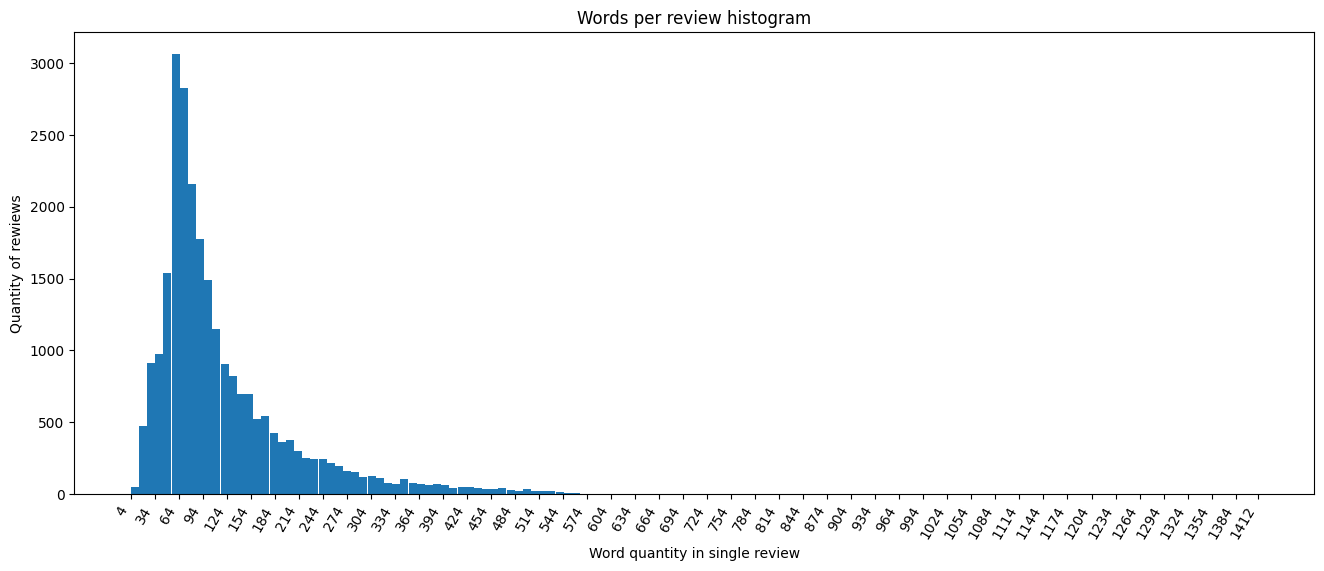

In [46]:
word_counts = sdv.make_count_histogram(reviews_train_binary, 30)


### Saving step 2 as a pickle

Because the data prepared in this step is ready for further processing it is saved as a picle as previously (end of step 1).

In [47]:
# Path to the file
output_file = "../datasets/reviews_train_binary_step_2.pickle"

# save the corpus as a pickle
with open(output_file, 'wb') as f:
    pickle.dump(reviews_train_binary, f)

# step 3 Stemming and Lemmatization

Stemming is rather most commodn approach in the case of english language. Lemmatization is more common in inflected languages (such as Polish) where getting words to the root doesn't work very well. Corpus lemmatization also takes longer than stemming, so it is used less often for that reason.

So why am I also considering lemmatization instead of stemming here? I would like to check whether the opinion I have come across that the combination of these two methods can give good results. At the end of this subsection, 3 versions of the processed corpus will be saved:

- after stemming only
- after lemmatization only
- afrer lemmatization and stemming together

### optional substep - Loading saved pickle

If you start this jupyter notebook from here, load the imports from the beginning section of the notebook and then run the cell below to get the preprocessed data:

In [48]:
# Load the data from pickle files

input_file = "../datasets/reviews_train_binary_step_2.pickle"

with open(input_file, 'rb') as f:
    reviews_train_binary = pickle.load(f)

## Stemming

`PorterStemmer()` is one way to do stemming - one of the most popular but there are others.
Stemming in some cases, such as: "integral" (integral), "integration" (integration) will also bring them to the same stem - even though these are different words when analyzing texts consisting of thousands of words we accept that some small percentage will be collectively classified under the same core.

In [49]:
reviews_train_stemming = scp.lemm_stemm(reviews_train_binary)

In [50]:
reviews_train_stemming[0]

'dan katzir produc wonder film take us rollercoast ride real romanc set troubl surround modern israelfor anyon who ever love film bring back uncertainti insecur heartach make love bittersweet atmospher fear isol came difficult time israel time serv intensifi feel instantli drawn dan plight cant fail deepli movedy cant write drama passion like contrast realiti dan desper snatch relationship iri realiti state turmoil make emin watchabl ounc passion ever love see film'

## Lemmatization

In [51]:
reviews_train_lemmatization = scp.lemm_stemm(reviews_train_binary, stemming=False, lemmatization=True)

In [52]:
reviews_train_lemmatization[0]

'dan katzir produce wonderful film take we rollercoaster ride real romance set trouble surround modern israelfor anyone who s ever love film bring back uncertainty insecurity heartache make love bittersweet atmosphere fear isolation come difficult time israel time serve intensify feel instantly draw dan plight can not fail deeply movedyou can not write drama passion like contrast reality dan desperate snatch relationship iris realitie state turmoil make eminently watchable ounce passion ever love see film'

## Lemmatization + Stemming

In [55]:
reviews_train_lemma_stemm = scp.lemm_stemm(reviews_train_lemmatization, stemming=True)

In [56]:
reviews_train_lemma_stemm[0]

'dan katzir produc wonder film take we rollercoast ride real romanc set troubl surround modern israelfor anyon who s ever love film bring back uncertainti insecur heartach make love bittersweet atmospher fear isol come difficult time israel time serv intensifi feel instantli draw dan plight can not fail deepli movedy can not write drama passion like contrast realiti dan desper snatch relationship iri realiti state turmoil make emin watchabl ounc passion ever love see film'


### Saving step 3 as a pickle

Data transformations from this point took a long time. Lemmatization lasted the longest, which was expected. Stemming works faster and in cases where short data preparation time is important, it will be a natural choice.

In order to be able to quickly reconstruct the results of this stage, as before, the record was made in the pickle format. It is particularly important to save data after lemmatization.

In [60]:
# Path to the file
output_file = "../datasets/reviews_train_lemmatization_step_3.pickle"

# save the corpus as a pickle
with open(output_file, 'wb') as f:
    pickle.dump(reviews_train_lemmatization, f)

# Path to the file
output_file = "../datasets/reviews_train_stemming_step_3.pickle"

# save the corpus as a pickle
with open(output_file, 'wb') as f:
    pickle.dump(reviews_train_stemming, f)

# Path to the file
output_file = "../datasets/reviews_train_lemmatization_step_3.pickle"

# save the corpus as a pickle
with open(output_file, 'wb') as f:
    pickle.dump(reviews_train_lemma_stemm, f)

# step 4: Conversion text data into tabular form

### optional substep - Loading saved pickles

If you start this jupyter notebook from here, load the imports from the beginning section of the notebook and then run the cell below to get the preprocessed data:

In [63]:
# Load the data from pickle files

input_file = "../datasets/reviews_train_stemming_step_3.pickle"

with open(input_file, 'rb') as f:
    reviews_train_stemming_step_4 = pickle.load(f)


input_file = "../datasets/reviews_train_lemmatization_step_3.pickle"

with open(input_file, 'rb') as f:
    reviews_train_lemmatization_step_4 = pickle.load(f)

input_file = "../datasets/reviews_train_lemmatization_step_3.pickle"

with open(input_file, 'rb') as f:
    reviews_train_lemmatization_step_4 = pickle.load(f)

## Bag of words

In [61]:
vectorizer = CountVectorizer()

In [64]:
vectorizer.fit(reviews_train_stemming_step_4)

CountVectorizer()

In [65]:
# word frequency matrix will have 108737 columns (i.e. words in the dictionary)

len(vectorizer.vocabularby_)

108737

In [ ]:
# (...) to be continued

#### Test data preprocessing

Preprocessing is conducted using methods defined after current step and the previows one. Both are defined in `supporting_modules/corpus_preprocessing`. Below run for testing purposes. 

In [58]:
# test the corpus preprocessing functions

reviews_test_test = scp.text_data_cleanup(reviews_test, get_info=True)

reviews_test_test = scp.preprocess_corpus(reviews_test_test)

print(reviews_test_test[0])

Applied pattern => \b(?:don't|aren't|couldn't|didn't|doesn't|hadn't|hasn't|haven't|isn't|mightn't|mustn't|needn't|shan't|shouldn't|wasn't|weren't|won't|wouldn't)\b
Applied pattern => \b(?:don|ain|aren|couldn|didn|doesn|hadn|hasn|haven|isn|mightn|mustn|needn|shan|shouldn|wasn|weren|won|wouldn)\b
hate heather graham shes beautiful hate shes fun watch movie like hip clothing funky surroundings actors flick work well together casey affleck hysterical heather graham literally lights screen minor characters goran visnjic sigh patricia velazquez talented gorgeous congratulations miramax director lisa krueger
